In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import torch
import matplotlib.pyplot as plt

from dataloaders import Dataloader, MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.layers import IntegrateAndFireOptimizedLayer
from spiking.evaluation import SpikingClassifierEvaluator
from spiking.utils import load_model, save_model

from visualization import ImagesVisualization

In [3]:
dataloader = MnistSpikesDataloader("../data/mnist-subset", 'train')
test_dataloader = MnistSpikesDataloader("../data/mnist-subset", 'test')
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")

max_input_spikes = 1568


In [18]:
def dataloader_to_spike_times(model: IntegrateAndFireOptimizedLayer, arg_dataloader: Dataloader):
    X, y = [], []
    for batch_idx, (spikes, label, _) in enumerate(arg_dataloader.iterate(batch_size=1), start=1):
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_z, max_x, max_y)):
            model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
        X.append(model.spike_times)
        y.append(label)
        model.reset()
    return torch.tensor(X), torch.tensor(y)

def eval_snn(model: IntegrateAndFireOptimizedLayer, classif=None, train: bool = False):
    evaluator = SpikingClassifierEvaluator(model, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
    print(f"{evaluator.X_train.shape = }, {evaluator.y_train.shape = }")
    print(f"{evaluator.X_test.shape = }, {evaluator.y_test.shape = }")

    evaluator.plot_reduced_dataset("train")
    evaluator.plot_reduced_dataset("val")
    evaluator.eval_classifier(classifier=classif, train=train)

def visualize_weights(model, neurons_indices=None):
    if neurons_indices is None:
        neurons_indices = range(model.num_outputs)

    for i in neurons_indices:
        imgs = model.weights[i].reshape((max_z, max_x, max_y)).detach().cpu().numpy()
        ImagesVisualization.plot_images(imgs[0], imgs[1], title=f"Weights {i}", ncols=2, cmap="gray")

evaluator.X_train.shape = (600, 100), evaluator.y_train.shape = (600,)
evaluator.X_test.shape = (100, 100), evaluator.y_test.shape = (100,)


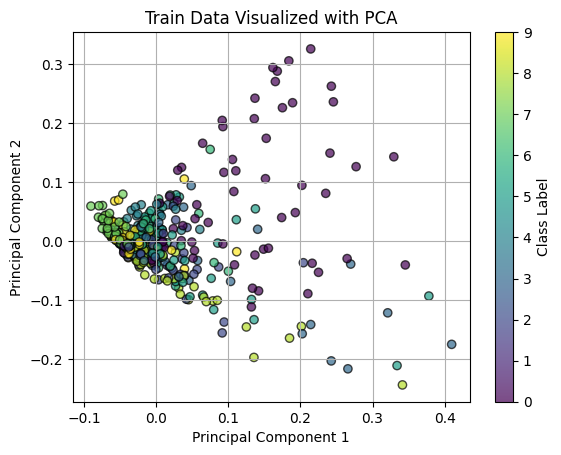

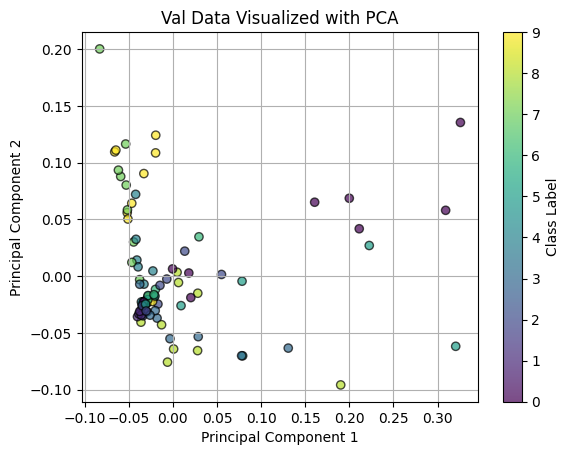

Train metrics:
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


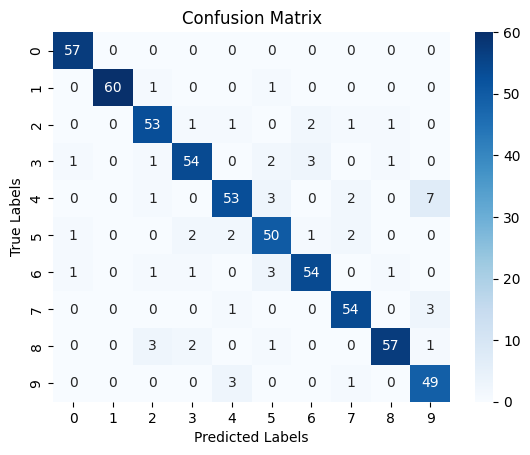

Validation metrics:
Accuracy: 0.79
Precision: 0.79
Recall: 0.84
F1 Score: 0.80


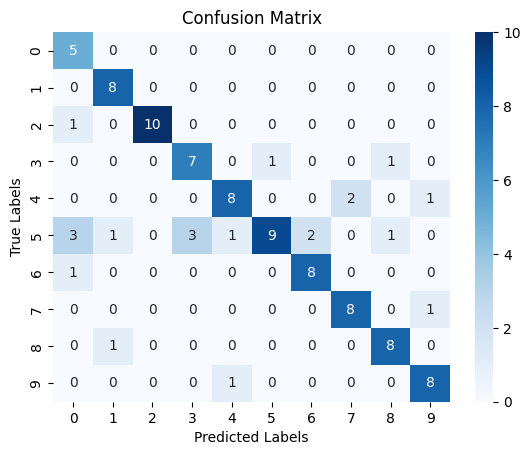

In [10]:
model_test = load_model('../checkpoints/model_test.pkl')
eval_snn(model_test, train=True)

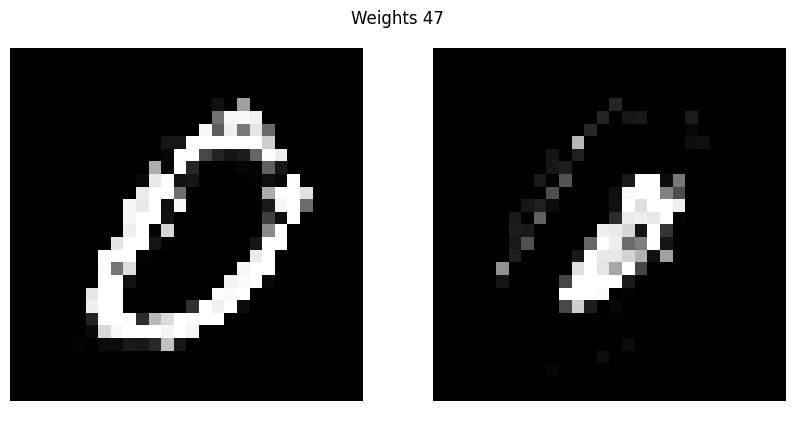

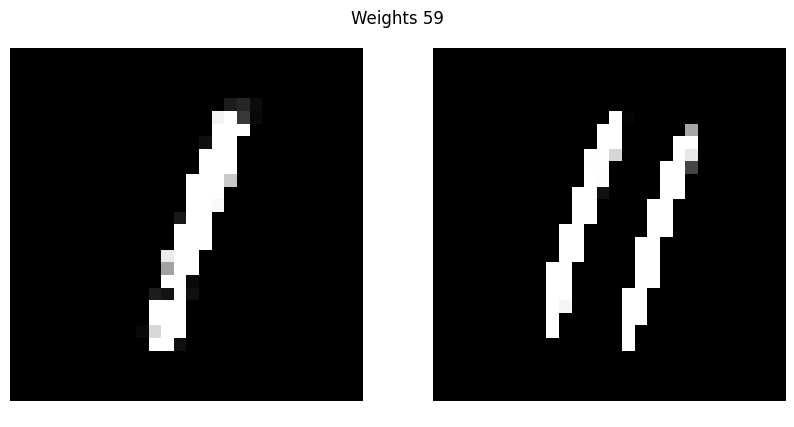

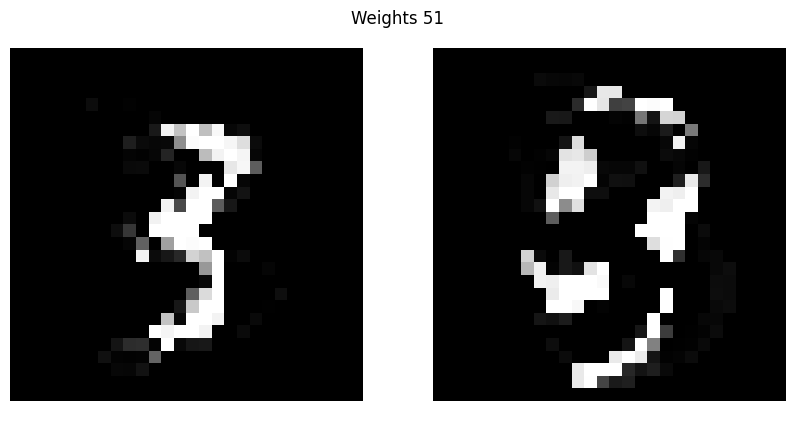

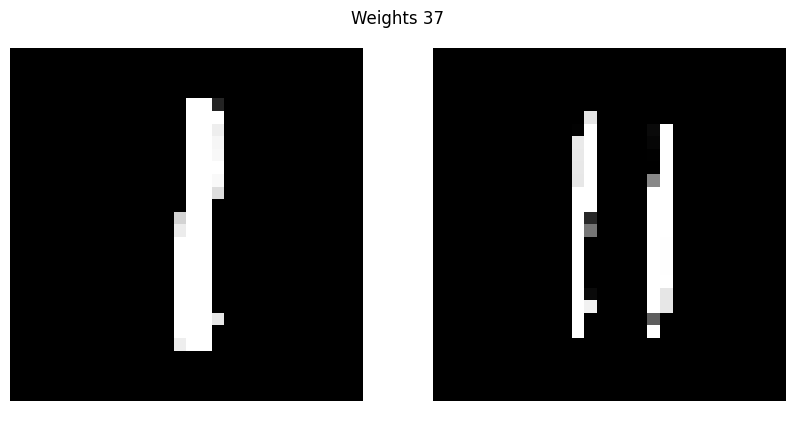

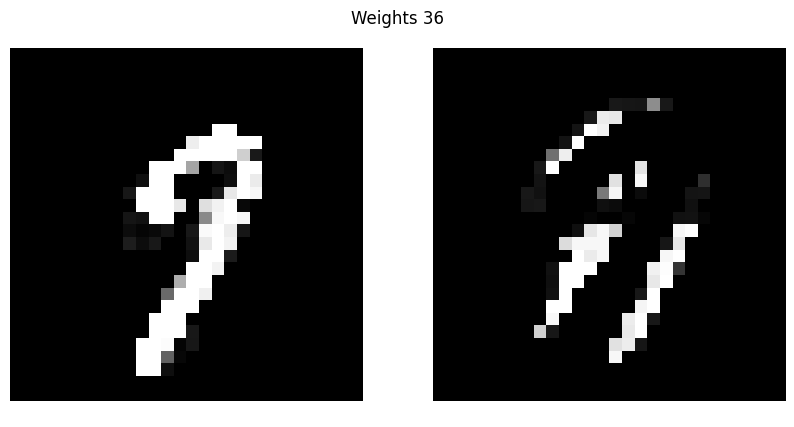

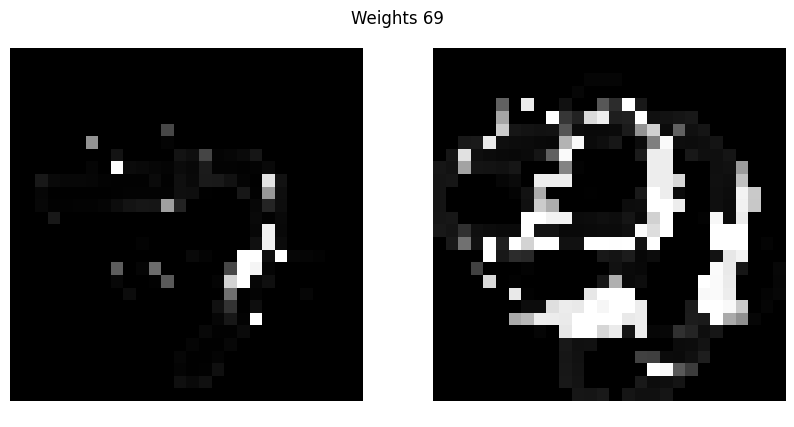

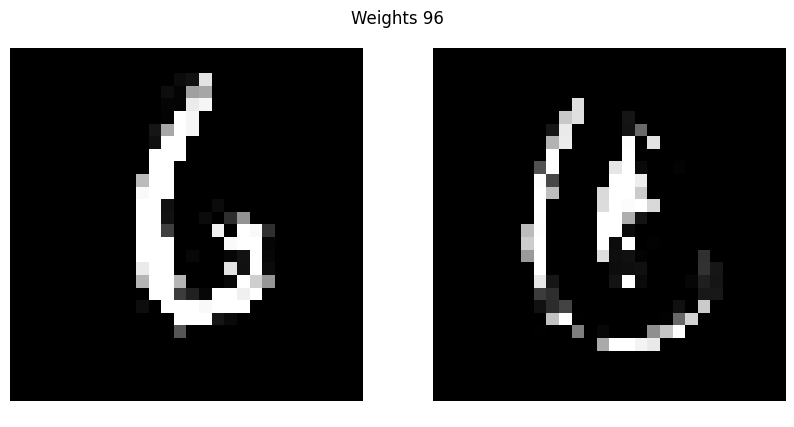

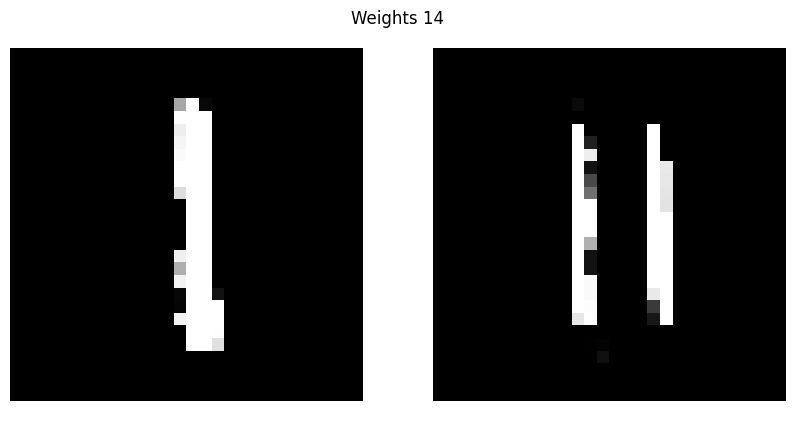

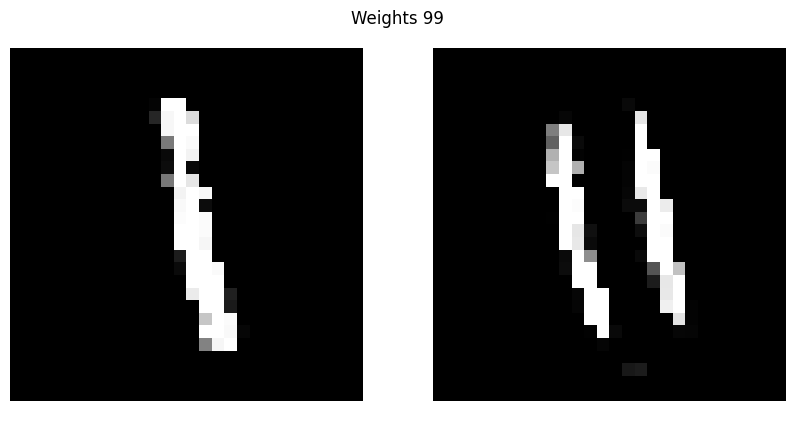

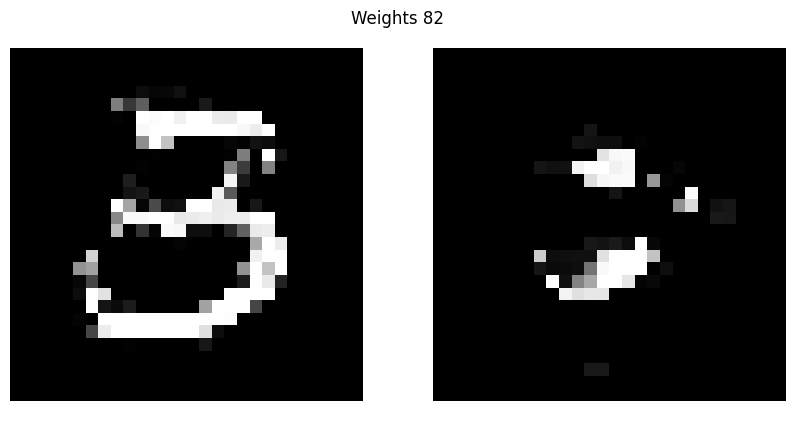

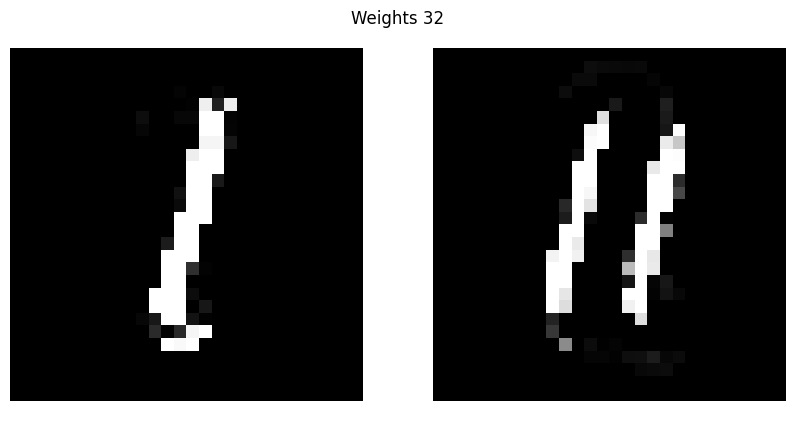

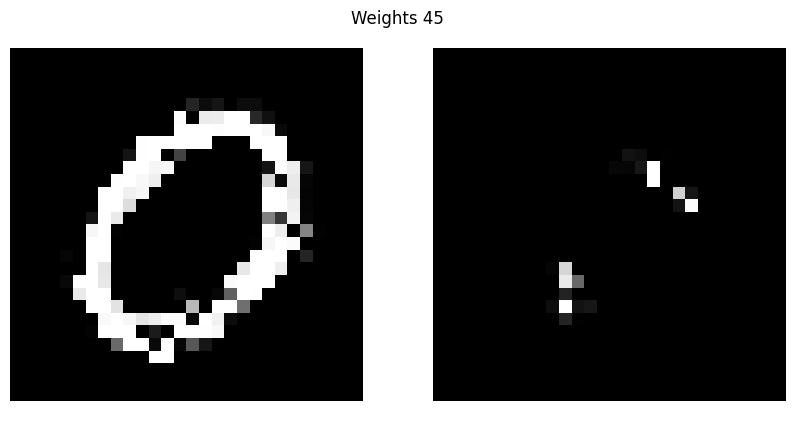

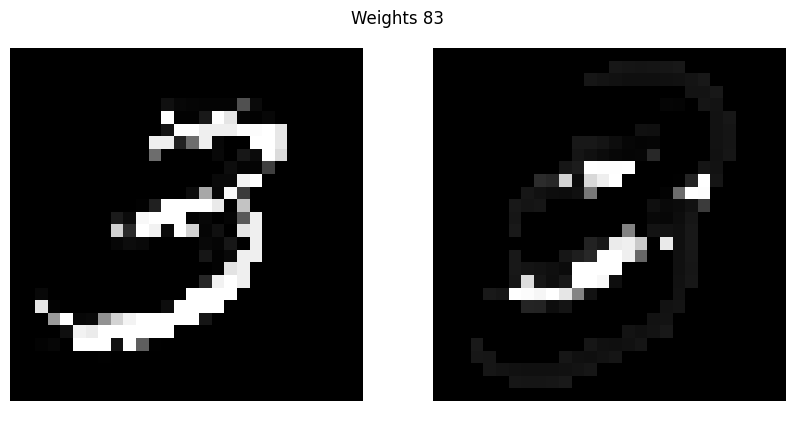

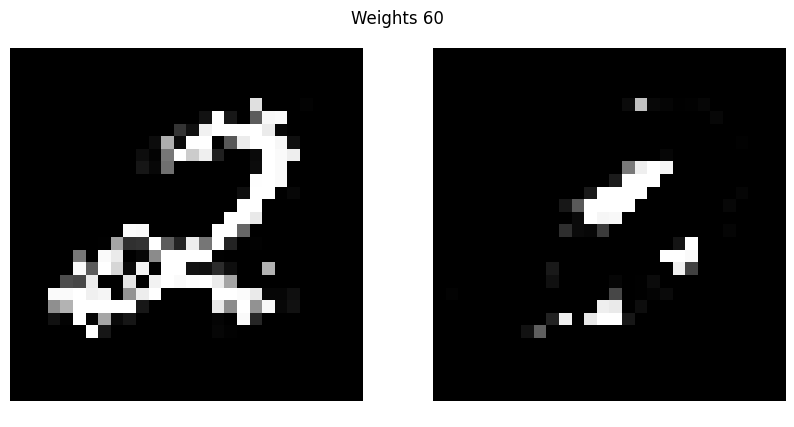

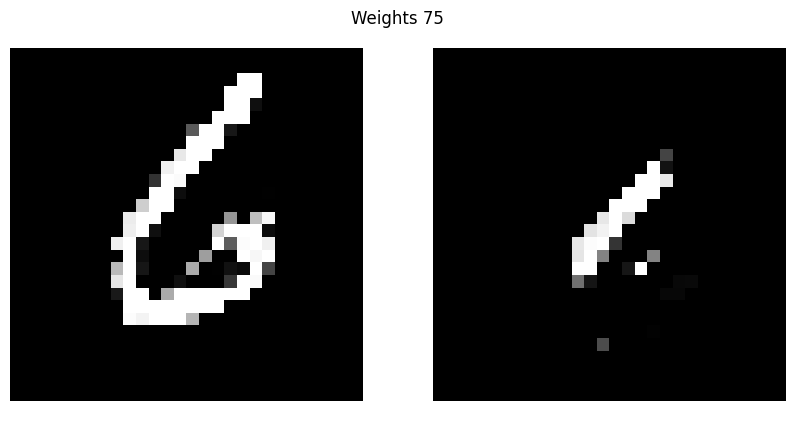

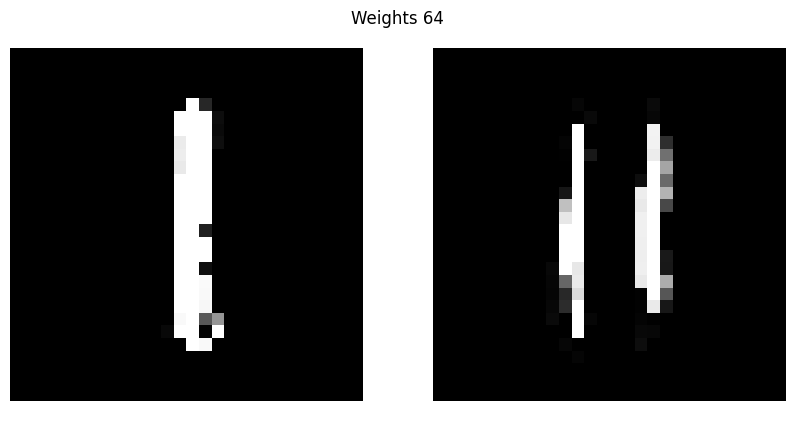

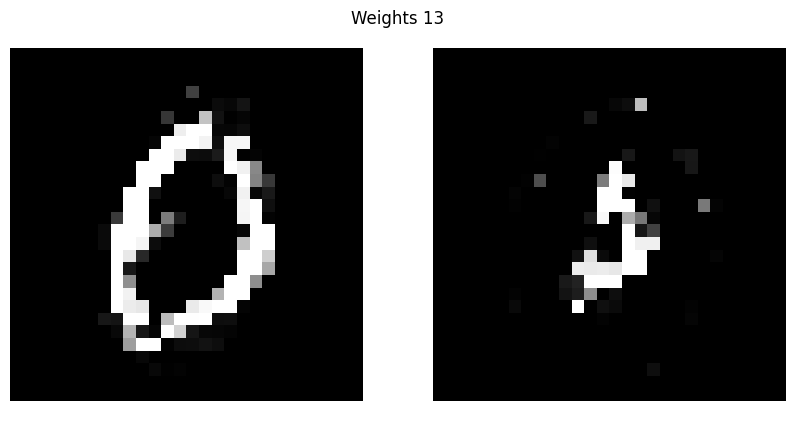

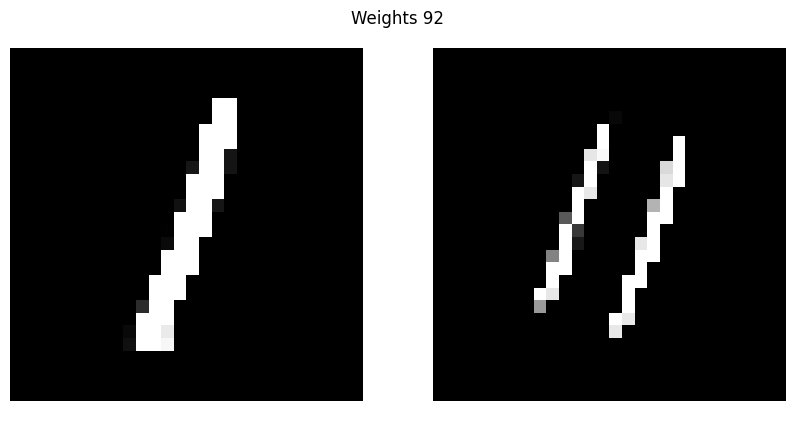

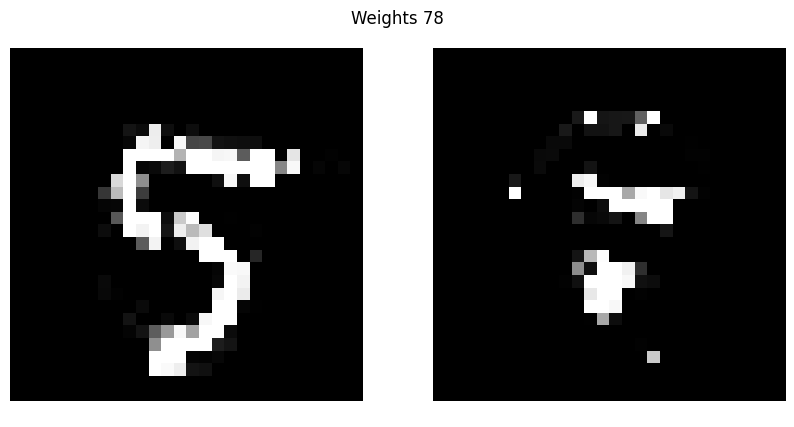

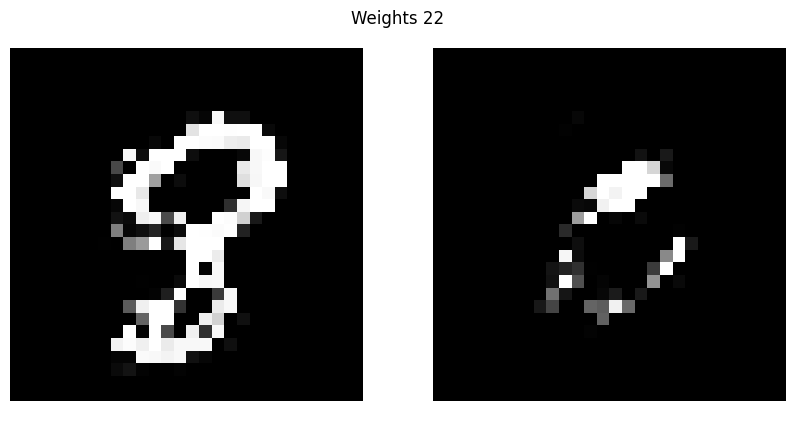

In [13]:
visualize_weights(model_test, torch.topk(model_test.thresholds, 20).indices.tolist())

(array([ 1.,  2.,  5.,  4.,  5., 10.,  8., 10., 11.,  8., 12.,  4.,  6.,
         4.,  2.,  3.,  2.,  2.,  0.,  1.]),
 array([ 48.93728638,  51.9289856 ,  54.920681  ,  57.9123764 ,
         60.90407562,  63.89577484,  66.88746643,  69.87916565,
         72.87086487,  75.86256409,  78.85426331,  81.8459549 ,
         84.83765411,  87.82935333,  90.82104492,  93.81274414,
         96.80444336,  99.79614258, 102.7878418 , 105.77953339,
        108.7712326 ]),
 <BarContainer object of 20 artists>)

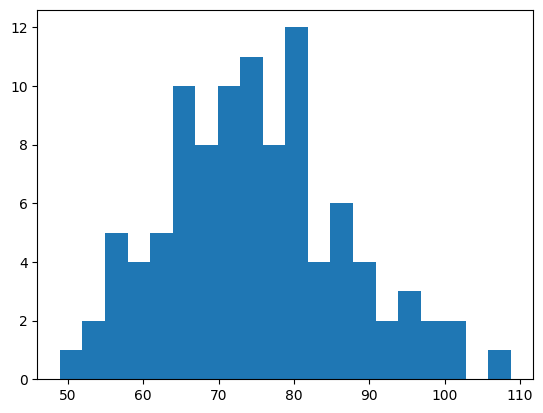

In [14]:
plt.hist(model_test.thresholds.numpy(), bins=20)

In [23]:
import tqdm
import torch.nn as nn
import torch.optim as optim

num_outputs = model_test.num_outputs
num_classes = 10

model_test.thresholds = nn.Parameter(model_test.thresholds)

In [53]:
def train_classifier(
    dataloader: Dataloader,
    spiking_model: IntegrateAndFireOptimizedLayer,
    classif_head: nn.Module,
    num_epochs: int = 20,
    batch_size: int = 1,
    optimizer=None,
):
    losses = []
    loss_fn = nn.CrossEntropyLoss()
    classif_head.train()
    pbar = tqdm.tqdm(range(0, num_epochs))

    batch = 0
    logits = torch.zeros((batch_size, num_classes))
    labels = torch.zeros((batch_size,)).long()

    for _ in pbar:
        for (spikes, label, _) in dataloader.iterate(batch_size=1, shuffle=True):
            spike_time_proxy = torch.zeros(spiking_model.num_outputs)
            for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_z, max_x, max_y)):
                surrogate_spikes = spiking_model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
                weight = 1.0 - current_time
                spike_time_proxy += surrogate_spikes * weight
                if torch.any(surrogate_spikes > 0):
                    break
            spiking_model.reset()

            logits[batch] = classif_head(spike_time_proxy)
            labels[batch] = label
            batch += 1

            if batch % batch_size == 0:
                loss = loss_fn(logits, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_postfix(loss=loss.item())
                losses.append(loss.item())
                batch = 0
                logits = torch.zeros((batch_size, num_classes))
                labels = torch.zeros((batch_size,)).long()

    plt.plot(losses)
    plt.title("Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()

## Train only classif head

100%|██████████| 10/10 [02:53<00:00, 17.39s/it, loss=2.26]


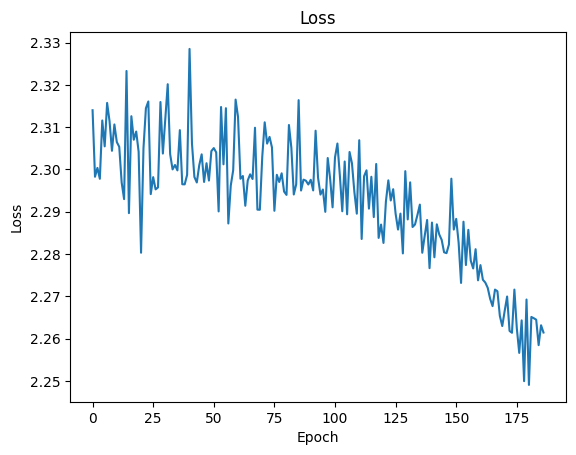

In [54]:
classif_head = nn.Linear(num_outputs, num_classes)

optimizer = optim.Adam(classif_head.parameters(), lr=0.001)
train_classifier(dataloader, model_test, classif_head, num_epochs=10, batch_size=32, optimizer=optimizer)

100%|██████████| 10/10 [02:49<00:00, 16.90s/it, loss=1.4]


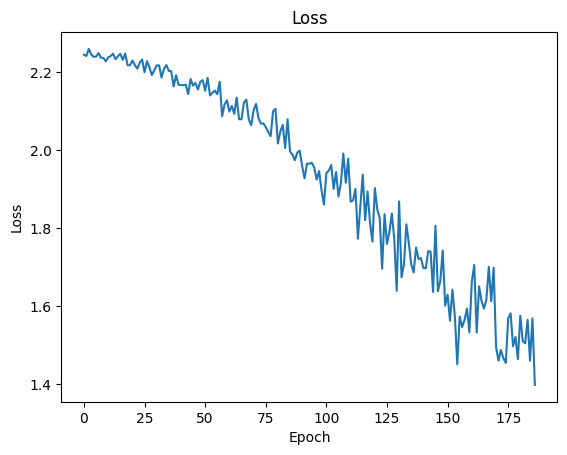

In [55]:
train_classifier(dataloader, model_test, classif_head, num_epochs=10, batch_size=32, optimizer=optimizer)

100%|██████████| 20/20 [05:37<00:00, 16.90s/it, loss=1.11] 


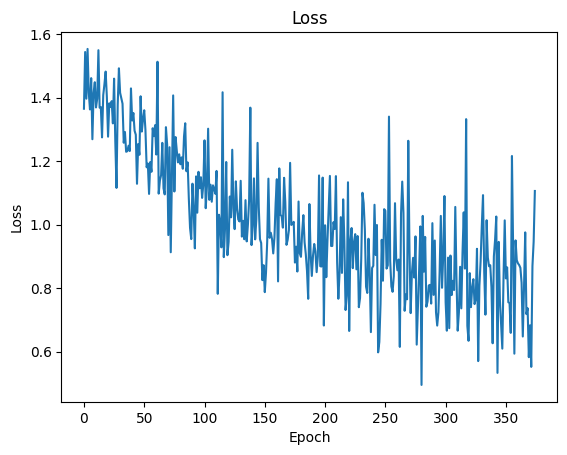

In [56]:
train_classifier(dataloader, model_test, classif_head, num_epochs=20, batch_size=32, optimizer=optimizer)

Train metrics:
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.76


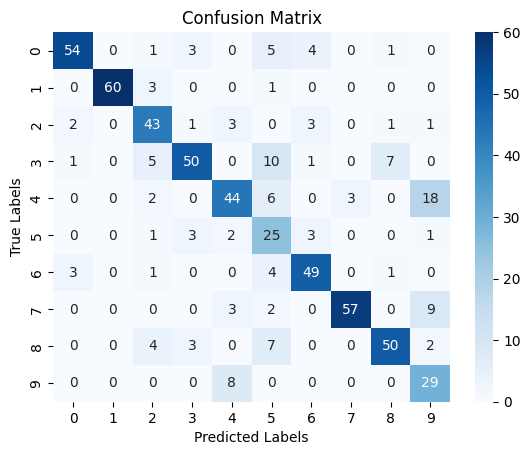

Validation metrics:
Accuracy: 0.71
Precision: 0.71
Recall: 0.73
F1 Score: 0.72


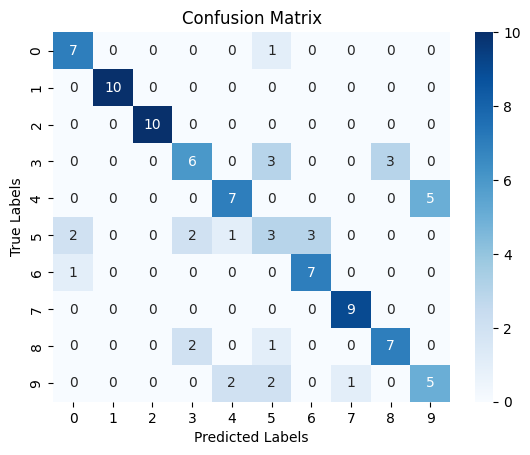

In [57]:
evaluator = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
evaluator.eval_classifier(classifier=classif_head)

## Train both classif and thresholds

100%|██████████| 10/10 [02:48<00:00, 16.90s/it, loss=2.22]


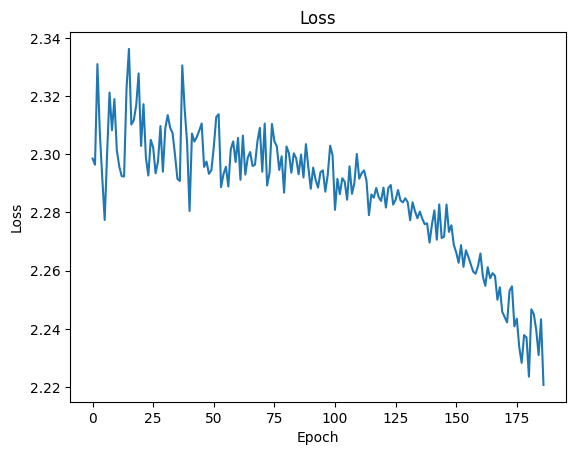

In [58]:
classif_head = nn.Sequential(
    nn.Linear(num_outputs, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, num_classes),
)
optimizer = optim.Adam([*classif_head.parameters(), model_test.thresholds], lr=0.001)
train_classifier(dataloader, model_test, classif_head, num_epochs=10, batch_size=32, optimizer=optimizer)

100%|██████████| 30/30 [09:22<00:00, 18.74s/it, loss=0.793]


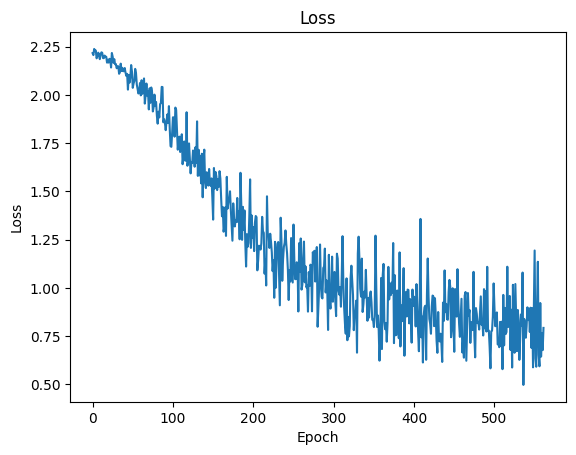

In [59]:
train_classifier(dataloader, model_test, classif_head, num_epochs=30, batch_size=32, optimizer=optimizer)

(array([1., 0., 0., 1., 1., 3., 2., 0., 2., 2., 2., 3., 2., 4., 4., 2., 4.,
        5., 4., 3., 1., 4., 8., 3., 3., 6., 5., 1., 1., 3., 3., 1., 4., 0.,
        2., 0., 2., 0., 2., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1.]),
 array([ 48.4838028 ,  49.67811966,  50.87243652,  52.0667572 ,
         53.26107407,  54.45539093,  55.64970779,  56.84402466,
         58.03834152,  59.23265839,  60.42697906,  61.62129593,
         62.81561279,  64.00993347,  65.20424652,  66.3985672 ,
         67.59288025,  68.78720093,  69.98152161,  71.17583466,
         72.37014771,  73.56446838,  74.75878906,  75.95310211,
         77.14742279,  78.34173584,  79.53605652,  80.7303772 ,
         81.92469025,  83.11901093,  84.31332397,  85.50764465,
         86.70196533,  87.89627838,  89.09059143,  90.28491211,
         91.47923279,  92.67355347,  93.86786652,  95.06217957,
         96.25650024,  97.45082092,  98.6451416 ,  99.83945465,
        101.0337677 , 102.22808838, 103.42240906, 104.61672211,
      

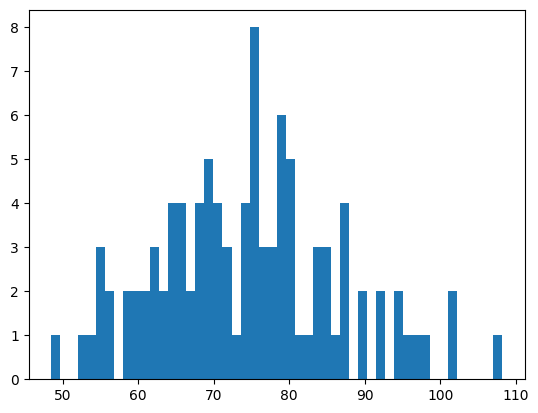

In [63]:
plt.hist(model_test.thresholds.detach().numpy(), bins=50)

Train metrics:
Accuracy: 0.77
Precision: 0.77
Recall: 0.76
F1 Score: 0.76


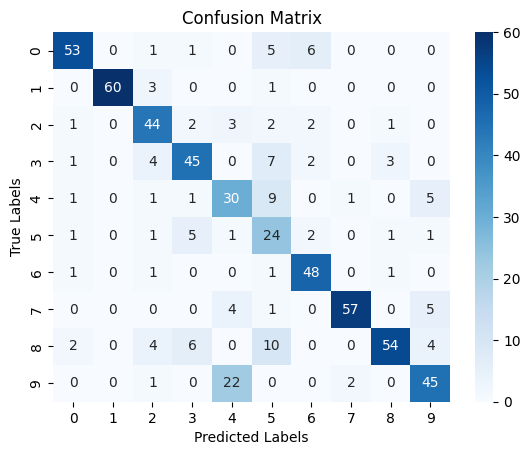

Validation metrics:
Accuracy: 0.72
Precision: 0.72
Recall: 0.73
F1 Score: 0.70


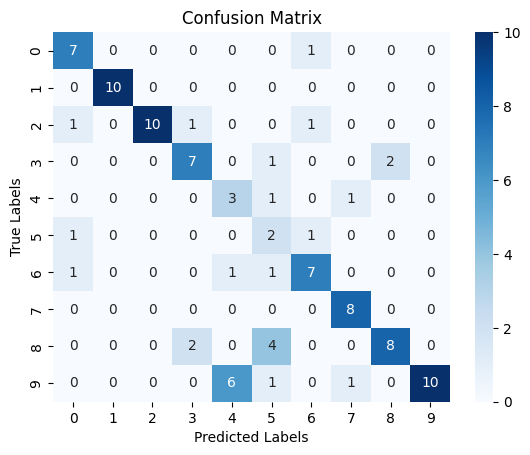

In [62]:
evaluator = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
evaluator.eval_classifier(classifier=classif_head)

In [65]:
save_model(model_test, "checkpoints/model_test2.pkl")

Train metrics:
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


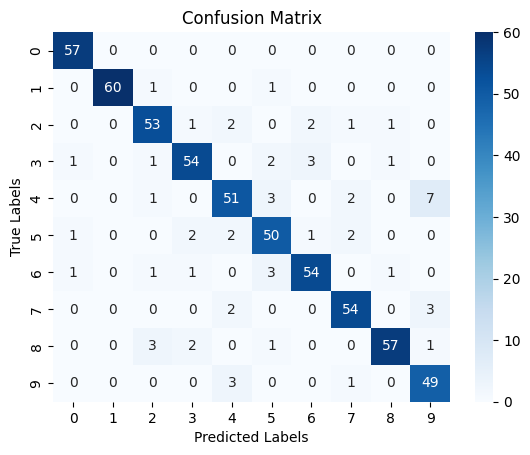

Validation metrics:
Accuracy: 0.82
Precision: 0.82
Recall: 0.85
F1 Score: 0.82


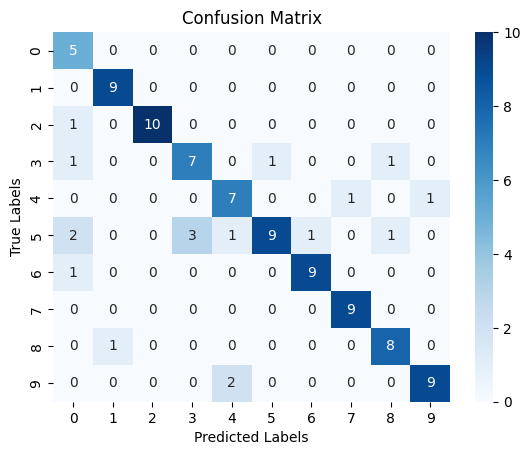

In [66]:
evaluator.eval_classifier(train=True)

100%|██████████| 100/100 [32:26<00:00, 19.46s/it, loss=0.521]


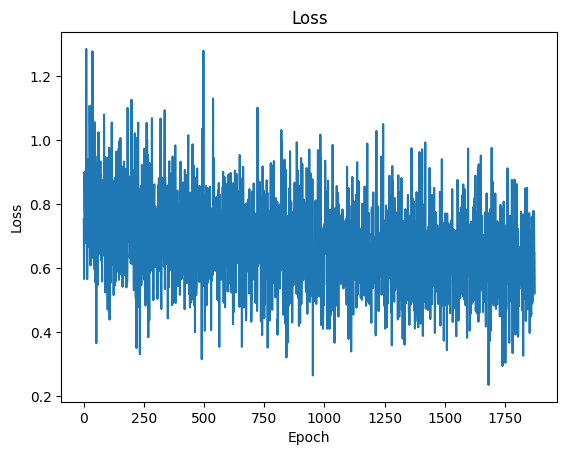

In [67]:
train_classifier(dataloader, model_test, classif_head, num_epochs=100, batch_size=32, optimizer=optimizer)

In [68]:
save_model(model_test, "checkpoints/model_test3.pkl")
model_test = load_model("checkpoints/model_test3.pkl")

Train metrics:
Accuracy: 0.81
Precision: 0.81
Recall: 0.82
F1 Score: 0.81


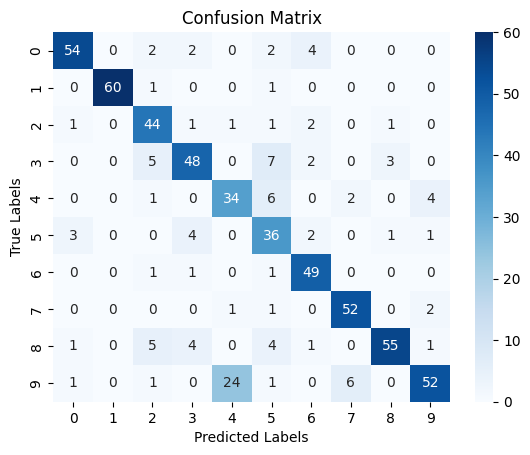

Validation metrics:
Accuracy: 0.82
Precision: 0.82
Recall: 0.84
F1 Score: 0.82


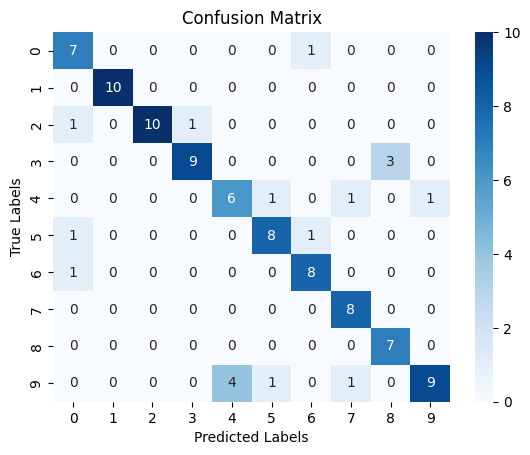

In [70]:
evaluator = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
evaluator.eval_classifier(classifier=classif_head)

Train metrics:
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


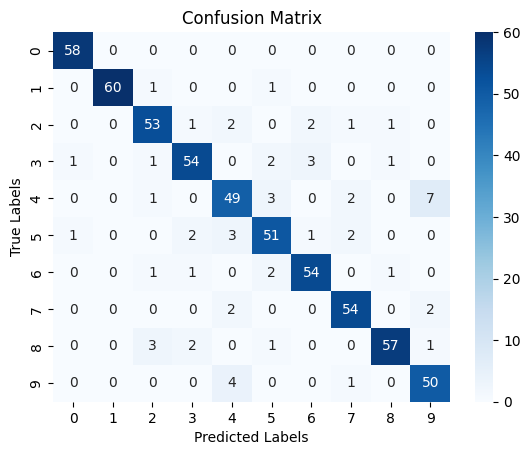

Validation metrics:
Accuracy: 0.84
Precision: 0.84
Recall: 0.86
F1 Score: 0.84


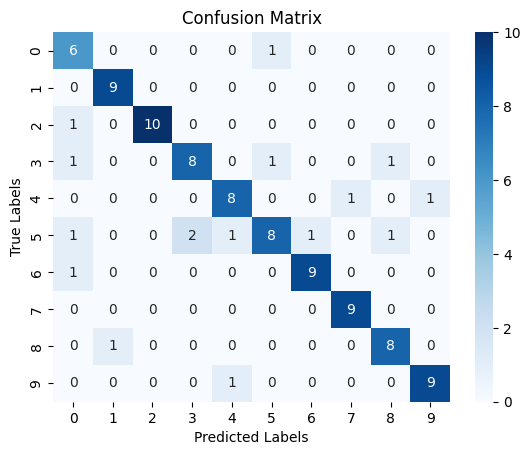

In [71]:
evaluator.eval_classifier(train=True)

(array([ 1.,  2.,  5.,  3.,  6., 10.,  9.,  9.,  9., 11., 10.,  6.,  5.,
         3.,  3.,  3.,  2.,  1.,  1.,  1.]),
 array([ 48.24097443,  51.20838928,  54.17580414,  57.14321899,
         60.11063004,  63.07804489,  66.04545593,  69.01287079,
         71.98028564,  74.9477005 ,  77.91511536,  80.88253021,
         83.84994507,  86.81735992,  89.78477478,  92.75218201,
         95.71960449,  98.68701172, 101.6544342 , 104.62184143,
        107.58925629]),
 <BarContainer object of 20 artists>)

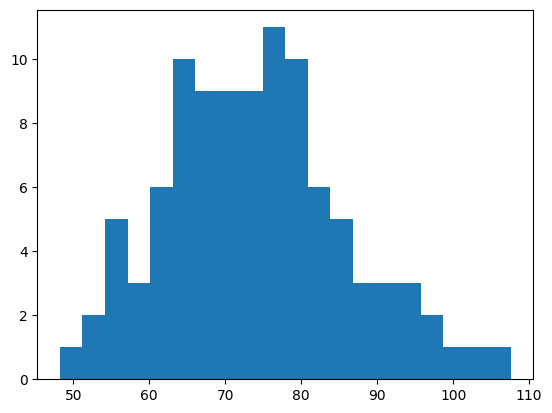

In [76]:
plt.hist(model_test.thresholds.detach().numpy(), bins=20)

(array([1., 0., 1., 1., 0., 3., 1., 2., 2., 0., 2., 3., 4., 3., 4., 2., 4.,
        5., 3., 4., 0., 5., 8., 2., 5., 4., 6., 1., 1., 4., 2., 1., 3., 1.,
        1., 1., 2., 0., 2., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.]),
 array([ 48.24097443,  49.42794037,  50.61490631,  51.80187225,
         52.9888382 ,  54.17580414,  55.36277008,  56.54973221,
         57.73669815,  58.92366409,  60.11063004,  61.29759598,
         62.48456192,  63.67152786,  64.85848999,  66.04545593,
         67.23242188,  68.41938782,  69.60635376,  70.7933197 ,
         71.98028564,  73.16725159,  74.35421753,  75.54118347,
         76.72814941,  77.91511536,  79.1020813 ,  80.28904724,
         81.47601318,  82.66297913,  83.84994507,  85.03691101,
         86.22387695,  87.4108429 ,  88.59780884,  89.78477478,
         90.97174072,  92.15870667,  93.34566498,  94.53263092,
         95.71959686,  96.90656281,  98.09352875,  99.28049469,
        100.46746063, 101.65442657, 102.84139252, 104.02835846,
      

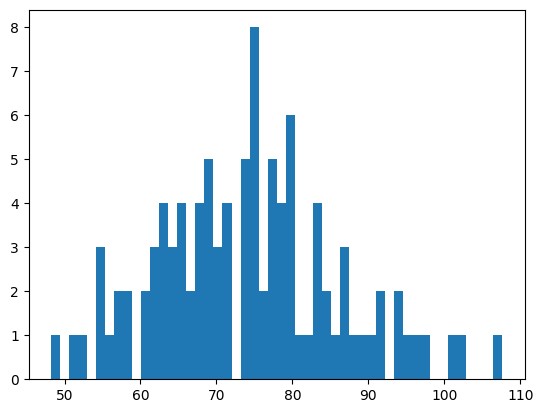

In [77]:
plt.hist(model_test.thresholds.detach().numpy(), bins=50)

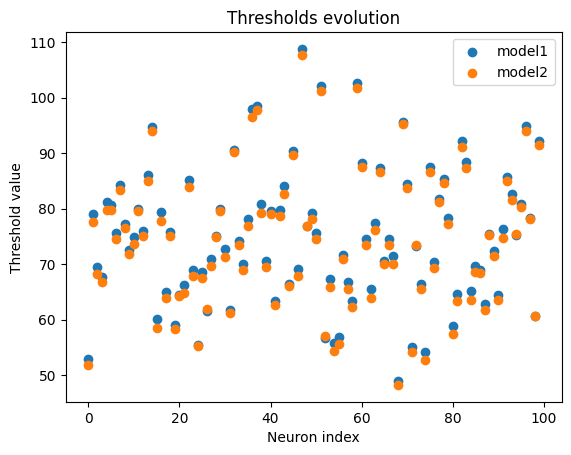

MSE: 1.0011398
Bigger thresholds in model2: 4 / 100
Mean before 74.994804 vs after 74.099815


In [99]:
import numpy as np

model1 = load_model("checkpoints/model_test.pkl")
model2 = load_model("checkpoints/model_test3.pkl")

x = np.arange(0, len(model_test.thresholds))
plt.scatter(x, model1.thresholds.detach().numpy(), label="model1", marker="o")
plt.scatter(x, model2.thresholds.detach().numpy(), label="model2", marker="o")
plt.legend()
plt.title("Thresholds evolution")
plt.xlabel("Neuron index")
plt.ylabel("Threshold value")
plt.show()

diff = model_test.thresholds - model1.thresholds
print("MSE:", diff.square().mean().sqrt().detach().numpy())

print("Bigger thresholds in model2:", torch.sum(diff > 0).item(), "/", len(diff))
print(
    "Mean before",
    model1.thresholds.mean().detach().numpy(),
    "vs after",
    model_test.thresholds.mean().detach().numpy()
)